# Study on Truncation Days and Reproduction Number

## Setup

In [1]:
import os
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

from utils.data import Shanghai

FIG_PATH = "./figs/"

In [2]:
def load_log(LOG_FILE):
    with open(LOG_FILE) as f:
        data = json.load(f)
        f.close()
    return data

## Load reported case sequence and reconstruct incidence data

In [3]:
sh = Shanghai()
sh.load_data()

## Reconstruction of Incidence

| Date | Before May 15 | After May 15|
|--|--|--|
|Mean of time-delay distribution| 4 | 2|


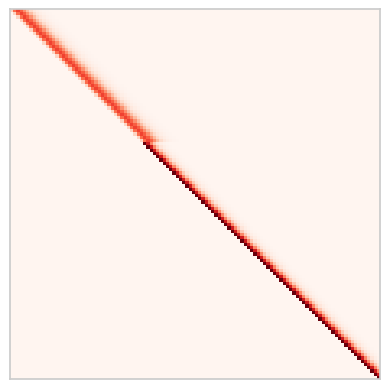

In [4]:
plt.xticks([], [])
plt.yticks([], [])
# plt.title("Time interval distribution")
# plt.xlabel("Probability")
# plt.ylabel("Days")

plt.imshow(sh.H, cmap=plt.cm.Reds)
# plt.colorbar()

plt.savefig(os.path.join(FIG_PATH, "TimeIntervalDistribution.svg"), bbox_inches="tight")
plt.show()

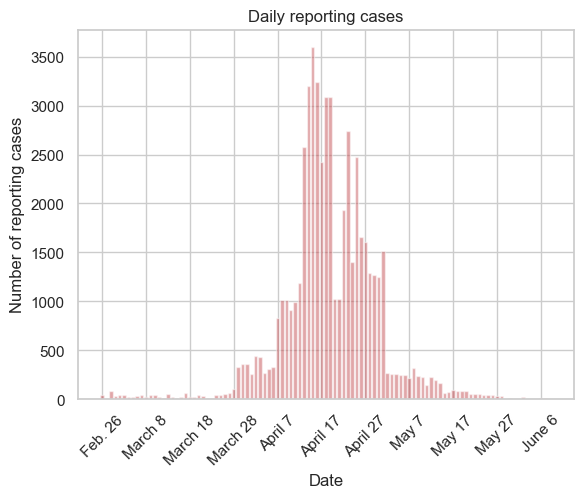

In [5]:
plt.xlabel("Date")
plt.ylabel("Number of reporting cases")
plt.title("Daily reporting cases")

plt.bar(range(len(sh.C)), sh.C, align='center', facecolor='r', alpha=.5)
ticks = np.arange(0, len(sh.C), 10)
labels = [sh.dates[i] for i in ticks]
plt.xticks(ticks=ticks, labels=labels, rotation=45)

plt.savefig(os.path.join(FIG_PATH, "DailyReportingCases.pdf"))
plt.show()

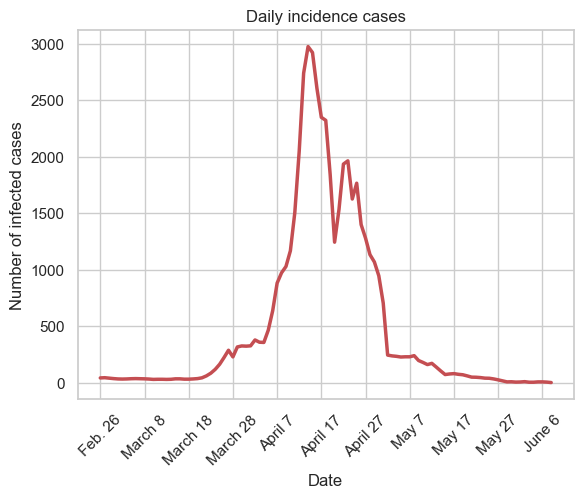

In [43]:
plt.xlabel("Date")
plt.ylabel("Number of infected cases")
plt.title("Daily incidence cases")

curve, = plt.plot(sh.I, c="r", linewidth=2.5)
ticks = np.arange(0, len(sh.C), 10)
labels = [sh.dates[i] for i in ticks]
plt.xticks(ticks=ticks, labels=labels, rotation=45)

plt.savefig(os.path.join(FIG_PATH, "DailyInfectionCases.pdf"))
plt.show()

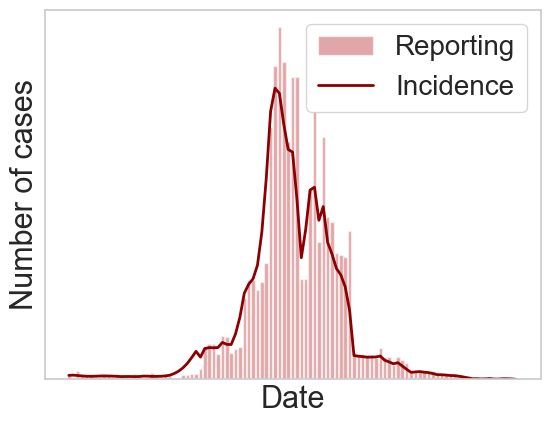

In [6]:
plt.xlabel("Date", fontsize=22)
plt.ylabel("Number of cases", fontsize=22)
# plt.title("Daily reporting and incidence cases", fontsize=20)

plt.xticks([], [])
plt.yticks([], [])

bar = plt.bar(range(len(sh.C)), sh.C, align='center', facecolor='r', alpha=.5)
curve, = plt.plot(sh.I, c="darkred", linewidth=2)

plt.legend(
    [bar, curve],
    ["Reporting", "Incidence"],
    fontsize=20
)

plt.savefig(os.path.join(FIG_PATH, "CI.svg"), bbox_inches="tight")
plt.show()

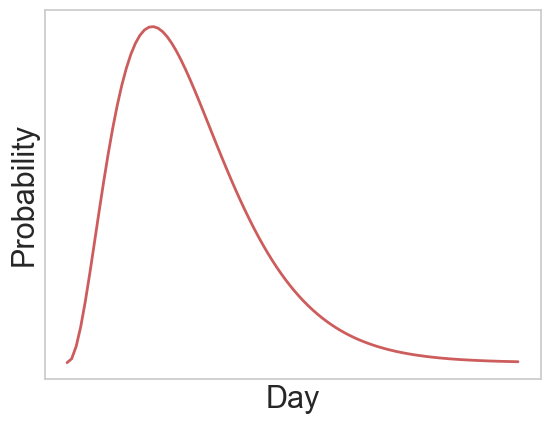

In [99]:
from scipy.stats import gamma

plt.xticks([], [])
plt.yticks([], [])
plt.xlabel("Day", fontsize=22)
plt.ylabel("Probability", fontsize=22)

x = np.linspace(0, 10, 100)
# plt.title("Serial interva distribution", fontsize=20)
plt.plot(gamma.pdf(x, a=sh.shape, scale=sh.scale), linewidth=2, c="indianred")

plt.savefig(os.path.join(FIG_PATH, "SerialInterval.svg"), bbox_inches="tight")
plt.show()

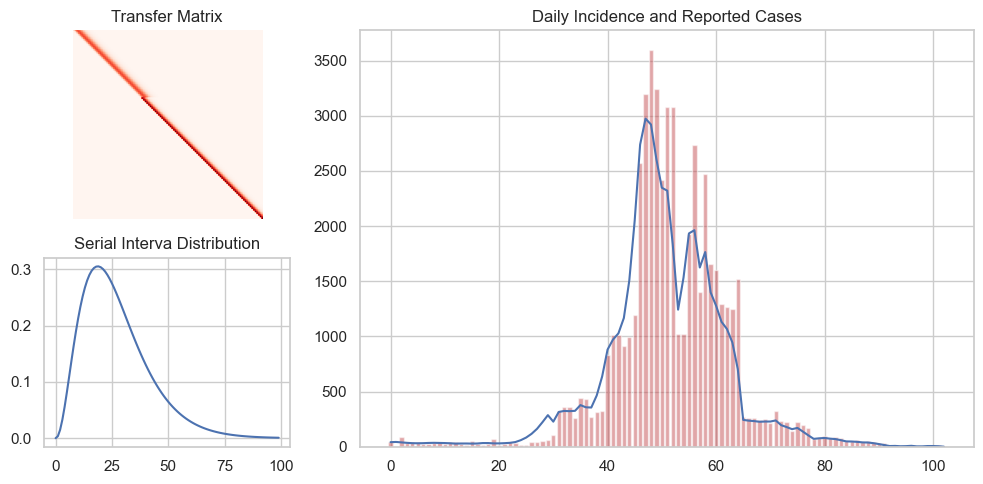

In [75]:
from scipy.stats import gamma

fig, axes = plt.subplots(ncols=2, nrows=2, gridspec_kw={'width_ratios': [2, 5]})
fig.set_size_inches(10, 5)

# remove the underlying axes
for ax in axes[:, -1]:
    ax.remove()
ax1, ax2 = axes[0, 0], axes[1, 0]

ax1.imshow(sh.H, cmap=plt.cm.Reds)
ax1.set_title("Transfer Matrix")
ax1.axis("off")

x = np.linspace(0, 10, 100)
ax2.set_title("Serial Interva Distribution")
ax2.plot(gamma.pdf(x, a=sh.shape, scale=sh.scale))

gs = axes[0, 1].get_gridspec()
axbig = fig.add_subplot(gs[:, -1])
axbig.plot(sh.I)
bar = axbig.bar(range(len(sh.C)), sh.C, align='center', facecolor='r', alpha=.5)
axbig.set_title("Daily Incidence and Reported Cases")

fig.tight_layout()
plt.show()

## Choosing hyperparameters

Before estimating low-level parameters of transmission model, we first explore possible number of structural breaks and their location. The changing of parameters of low-level transmission model is modelled by Gaussian random walk, of which deviation changes at structural break $d_i$
$$
T \circ p(\theta) =
\left\{\begin{aligned}
&p(\theta)K_{\sigma_1}(\theta),\ 0<t<d_1;\\
&p(\theta)K_{\sigma_2}(\theta),\ d_1<t<d_2; \\
&\quad\cdots \\
&p(\theta)K_{\sigma_n}(\theta),\ d_{n-1}<t<d_n.
\end{aligned}\right.
$$
This step is completed with optuna by maximizing evidence.

In [4]:
hp_file = "./logs/BestHyperParams-2022-11-12-21-27-19.json"
with open(hp_file) as f: 
    hpDict = json.load(f)
    f.close()

In [5]:
print(f"First structural break point: {sh.dates[hpDict['t1']]}")
print(f"Second structural break point: {sh.dates[hpDict['t2']]}")

First structural break point: April 1
Second structural break point: May 2


## Estimating low-level parameters

Low-level parameters are estimated based on hyperparameters chosen in the last step.

In [6]:
from utils.model import myStudy

hp_file = "./logs/BestHyperParams-2022-11-12-21-27-19.json"
with open(hp_file) as f: 
    hpDict = json.load(f)
    f.close()
S = myStudy(data_seg=sh.data_seg, hpDict=hpDict, silent=False)
res = S.estimate_params()

+ Created new study.
+ Successfully imported array.
+ Observation model: likelihood. Parameter(s): ('R', 'D')
+ Transition model: Serial transition model. Hyper-Parameter(s): ['s1R', 's1D', 's2R', 's2D', 's3R', 's3D', 't1', 't2']
+ Started new fit:
    + Formatted data.
    + Set uniform prior with parameter boundaries.


  0%|          | 0/103 [00:00<?, ?it/s]

    + Finished forward pass.
    + Log10-evidence: -229.84337


  0%|          | 0/103 [00:00<?, ?it/s]

    + Finished backward pass.
    + Computed mean parameter values.


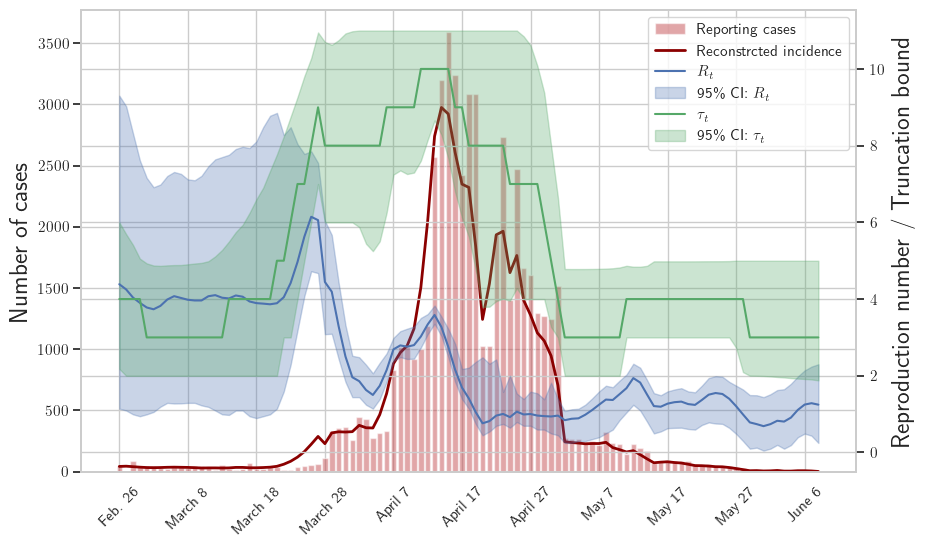

In [10]:
f, ax1 = plt.subplots(1, 1, figsize=(10, 6))
# plt.rcParams['text.usetex'] = True
lw = 2

barC = ax1.bar(S.rawTimestamps, sh.C, align='center', facecolor='r', alpha=.5)
curveI, = ax1.plot(S.rawTimestamps, sh.I, c='darkred', linewidth=lw)
ax1.set_ylabel(r"Number of cases", fontsize=18)

ax2 = ax1.twinx()
ax2.set_ylabel(r"Reproduction number / Truncation bound", fontsize=18)
curveR, = ax2.plot(S.rawTimestamps, S.getParameterMeanValues("R"), 'b')
R_lowers, R_uppers = res["R"]["lowers"], res["R"]["uppers"]
contourR = ax2.fill_between(S.rawTimestamps, R_lowers, R_uppers, alpha=0.3, color="b")

Ds = [int(D) for D in S.getParameterMeanValues("D")]
curveD, = ax2.plot(S.rawTimestamps, Ds, 'g')
D_lowers, D_uppers = res["D"]["lowers"], res["D"]["uppers"]
contourD = ax2.fill_between(S.rawTimestamps, D_lowers, D_uppers, alpha=0.3, color="g")

ticks = np.arange(0, len(sh.C), 10)
labels = [sh.dates[i] for i in ticks]
ax1.set_xticks(ticks=ticks, labels=labels, rotation=45)

plt.legend(
    [barC, curveI, curveR, contourR, curveD, contourD, ],
    ["Reporting cases", "Reconstrcted incidence", "$R_t$", 
    "95\% CI: $R_t$", r"$\tau_t$", r"95\% CI: $\tau_t$"],
     loc="upper right",

)

plt.savefig(os.path.join(FIG_PATH, "Fig3.svg"))
plt.show()

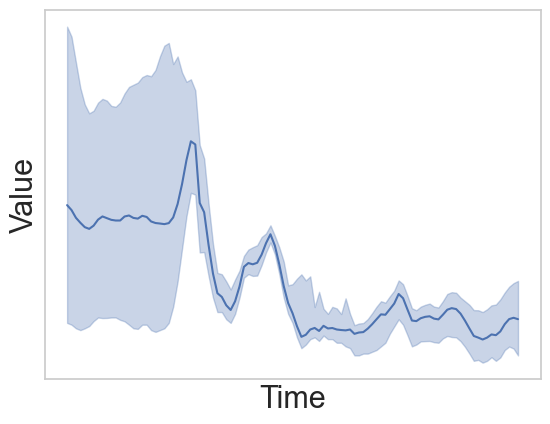

In [100]:
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel("Time", fontsize=22)
plt.ylabel("Value", fontsize=22)

curveR, = plt.plot(S.rawTimestamps, S.getParameterMeanValues("R"), 'b')
R_lowers, R_uppers = res["R"]["lowers"], res["R"]["uppers"]
contourR = plt.fill_between(S.rawTimestamps, R_lowers, R_uppers, alpha=0.3, color="b")

plt.savefig(os.path.join(FIG_PATH, "EstimParams.svg"), bbox_inches="tight")
plt.show()